# AXA Datachallenge v1

## Table of Content

<ol>
    <li>[LIBRARY IMPORTS](#library)</li>
    <li>[LOAD DATA](#load)</li>
    <li>
        [DATA PRE-PROCESSING](#pre-processing)
        <ol>
            <li>[Column Dropping](#column-dropping)</li>
            <li>
                [Format Data](#format-data)
            </li>
        </ol>
    </li>
    <li>[PREDICTION](#prediction)</li>
</ol>

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import re
import operator
from collections import defaultdict, Counter
import warnings
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load data with limit to 10000
# data = pd.read_csv('../train_2011_2012_2013.csv', sep=';', nrows=10000)
# Load full data
data = pd.read_csv('train_2011_2012_2013.csv', sep=';')

In [3]:
data = data[['DATE', 'ASS_ASSIGNMENT', 'CSPL_CALLS']]

In [4]:
data.head()

,DATE,ASS_ASSIGNMENT,CSPL_CALLS
0,2011-04-24 01:30:00.000,Téléphonie,0
1,2011-04-24 01:30:00.000,Téléphonie,0
2,2011-04-24 01:30:00.000,Téléphonie,0
3,2011-04-24 01:30:00.000,Téléphonie,0
4,2011-04-24 01:30:00.000,Téléphonie,1


In [5]:
# Nombre de calls
sum(data.CSPL_CALLS)

10547647

In [6]:
# Date without '-', ':' and final 0
def simplifyDATE(x):
    return re.sub(r'[^\w]', '', x)[:12]

In [7]:
data['DATE'] = data['DATE'].map(simplifyDATE)

In [8]:
data.head()

,DATE,ASS_ASSIGNMENT,CSPL_CALLS
0,201104240130,Téléphonie,0
1,201104240130,Téléphonie,0
2,201104240130,Téléphonie,0
3,201104240130,Téléphonie,0
4,201104240130,Téléphonie,1


In [9]:
print(min(data.DATE))
print(max(data.DATE))

201101010000
201312312330


In [10]:
NUMBER_DAYS = 3*365/2 ## Ici on divise par deux pour 
print(NUMBER_DAYS)

547.5


In [11]:
#colonne HOURMIN pour les heures et minutes
data['HOURMIN'] = data['DATE'].map(lambda x: x[8:])

In [12]:
data.head()

,DATE,ASS_ASSIGNMENT,CSPL_CALLS,HOURMIN
0,201104240130,Téléphonie,0,0130
1,201104240130,Téléphonie,0,0130
2,201104240130,Téléphonie,0,0130
3,201104240130,Téléphonie,0,0130
4,201104240130,Téléphonie,1,0130


In [13]:
def getWeekDayRow(x):
    return datetime.datetime(int(x[:4]), int(x[4:6]), int(x[6:8]), int(x[8:10]), int(x[10:12])).weekday()

def getWeekDay(data):
    data['WEEKDAY'] = data['DATE'].map(getWeekDayRow)

In [18]:
getWeekDay(data)

In [20]:
print(datetime.datetime(2016,12,11,11,34).weekday())
#return 6 for sundays

6


In [19]:
data.head()

,DATE,ASS_ASSIGNMENT,CSPL_CALLS,HOURMIN,WEEKDAY
0,201104240130,Téléphonie,0,0130,6
1,201104240130,Téléphonie,0,0130,6
2,201104240130,Téléphonie,0,0130,6
3,201104240130,Téléphonie,0,0130,6
4,201104240130,Téléphonie,1,0130,6


In [22]:
groupbydata = data.groupby(['HOURMIN', 'ASS_ASSIGNMENT'])['CSPL_CALLS'].sum()
groupbydata.head()

HOURMIN  ASS_ASSIGNMENT
0000     CAT                 5
         CMS                 0
         Crises              0
         Domicile          171
         Evenements        200
Name: CSPL_CALLS, dtype: int64

In [23]:
groupbydatamean = groupbydata/NUMBER_DAYS
groupbydatamean.head()

HOURMIN  ASS_ASSIGNMENT
0000     CAT               0.009132
         CMS               0.000000
         Crises            0.000000
         Domicile          0.312329
         Evenements        0.365297
Name: CSPL_CALLS, dtype: float64

In [24]:
sum(groupbydata['1400'])

426712

In [28]:
sub = pd.read_csv('submission.txt', sep='\t')
sub.head()

,DATE,ASS_ASSIGNMENT,prediction
0,2012-12-28 00:00:00.000,CMS,0
1,2012-12-28 00:00:00.000,Crises,0
2,2012-12-28 00:00:00.000,Domicile,0
3,2012-12-28 00:00:00.000,Gestion,0
4,2012-12-28 00:00:00.000,Gestion - Accueil Telephonique,0


In [29]:
sub['NEW_DATE'] = sub['DATE'].map(simplifyDATE).map(lambda x: x[8:])
sub['CONCAT'] = sub.NEW_DATE.str.cat(sub.ASS_ASSIGNMENT)

In [30]:
def predict(concatcell):
    hourmin = concatcell[:4]
    ass_assignement = concatcell[4:]
    return groupbydatamean[hourmin][ass_assignement]

In [31]:
sub['prediction'] = sub.CONCAT.map(predict)


In [32]:
sub

,DATE,ASS_ASSIGNMENT,prediction,NEW_DATE,CONCAT
0,2012-12-28 00:00:00.000,CMS,0.000000,0000,0000CMS
1,2012-12-28 00:00:00.000,Crises,0.000000,0000,0000Crises
2,2012-12-28 00:00:00.000,Domicile,0.312329,0000,0000Domicile
3,2012-12-28 00:00:00.000,Gestion,0.000000,0000,0000Gestion
4,2012-12-28 00:00:00.000,Gestion - Accueil Telephonique,0.009132,0000,0000Gestion - Accueil Telephonique
5,2012-12-28 00:00:00.000,Gestion Assurances,0.000000,0000,0000Gestion Assurances
6,2012-12-28 00:00:00.000,Gestion Relation Clienteles,0.000000,0000,0000Gestion Relation Clienteles
7,2012-12-28 00:00:00.000,Gestion Renault,0.000000,0000,0000Gestion Renault
8,2012-12-28 00:00:00.000,Japon,0.551598,0000,0000Japon
9,2012-12-28 00:00:00.000,Médical,0.803653,0000,0000Médical


In [34]:
sub.drop(['NEW_DATE', 'CONCAT'], axis=1, inplace=True)

In [35]:
def save(data, title):
    data.to_csv(title + '.txt', sep='\t', index=False)

In [36]:
save(sub, 'nine')

In [37]:
def splitDate(data):
    data['YEAR'] = data['DATE'].map(lambda x: int(x[:4]))
    data['MONTH'] = data['DATE'].map(lambda x: int(x[4:6]))
    data['DAY'] = data['DATE'].map(lambda x: int(x[6:8]))
    data['HOUR'] = data['DATE'].map(lambda x: int(x[8:10]))
    data['MIN'] = data['DATE'].map(lambda x: int(x[10:12]))

In [38]:
splitDate(data)

In [39]:
data.head()

,DATE,ASS_ASSIGNMENT,CSPL_CALLS,HOURMIN,WEEKDAY,YEAR,MONTH,DAY,HOUR,MIN
0,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30
1,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30
2,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30
3,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30
4,201104240130,Téléphonie,1,0130,6,2011,4,24,1,30


In [40]:
def getWeekDayRow(x):
    return datetime.datetime(int(x[:4]), int(x[4:6]), int(x[6:8]), int(x[8:10]), int(x[10:12])).weekday()

def getWeekDay(data):
    data['WEEKDAY'] = data['DATE'].map(getWeekDayRow)

In [41]:
getWeekDay(data)

In [42]:
data.head()

,DATE,ASS_ASSIGNMENT,CSPL_CALLS,HOURMIN,WEEKDAY,YEAR,MONTH,DAY,HOUR,MIN
0,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30
1,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30
2,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30
3,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30
4,201104240130,Téléphonie,1,0130,6,2011,4,24,1,30


In [43]:
def isWeekEnd(x):
    return 1 if datetime.datetime(int(x[:4]), int(x[4:6]), int(x[6:8]), int(x[8:10]), int(x[10:12])).weekday() in [5, 6] else 0

def getWeekEnd(data):
    data['WEEKEND'] = data['DATE'].map(isWeekEnd)

In [44]:
getWeekEnd(data)

In [45]:
data.head()

,DATE,ASS_ASSIGNMENT,CSPL_CALLS,HOURMIN,WEEKDAY,YEAR,MONTH,DAY,HOUR,MIN,WEEKEND
0,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30,1
1,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30,1
2,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30,1
3,201104240130,Téléphonie,0,0130,6,2011,4,24,1,30,1
4,201104240130,Téléphonie,1,0130,6,2011,4,24,1,30,1


In [46]:
data['HOURMIN'] = data['DATE'].map(lambda x: x[8:])
data['HOURMIN_ASSIGNEMENT'] = data.HOURMIN.str.cat(data.ASS_ASSIGNMENT)
data = data.drop('HOURMIN', 1)

In [53]:
data.head(10)

,DATE,ASS_ASSIGNMENT,CSPL_CALLS,WEEKDAY,YEAR,MONTH,DAY,HOUR,MIN,WEEKEND,HOURMIN_ASSIGNEMENT
0,201104240130,Téléphonie,0,6,2011,4,24,1,30,1,0130Téléphonie
1,201104240130,Téléphonie,0,6,2011,4,24,1,30,1,0130Téléphonie
2,201104240130,Téléphonie,0,6,2011,4,24,1,30,1,0130Téléphonie
3,201104240130,Téléphonie,0,6,2011,4,24,1,30,1,0130Téléphonie
4,201104240130,Téléphonie,1,6,2011,4,24,1,30,1,0130Téléphonie
5,201104250130,RTC,0,0,2011,4,25,1,30,0,0130RTC
6,201104250130,Gestion Renault,0,0,2011,4,25,1,30,0,0130Gestion Renault
7,201104250130,RTC,0,0,2011,4,25,1,30,0,0130RTC
8,201104250130,Nuit,5,0,2011,4,25,1,30,0,0130Nuit
9,201104250130,Gestion - Accueil Telephonique,0,0,2011,4,25,1,30,0,0130Gestion - Accueil Telephonique


In [50]:
hourmin_ass_counter = Counter(data.HOURMIN_ASSIGNEMENT)
#print(hourmin_ass_counter)

In [54]:
occByHourMinByAssignement = defaultdict(dict)
for item in hourmin_ass_counter.items():
    occByHourMinByAssignement[item[0][4:]][item[0][:4]] = item[1]

In [55]:
#occByHourMinByAssignement

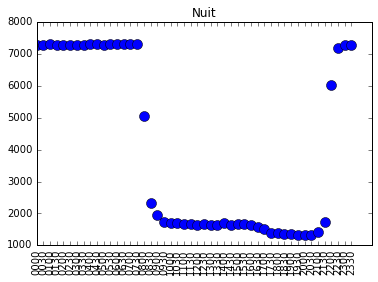

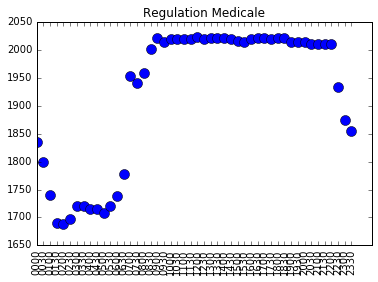

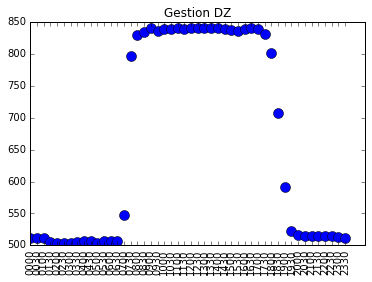

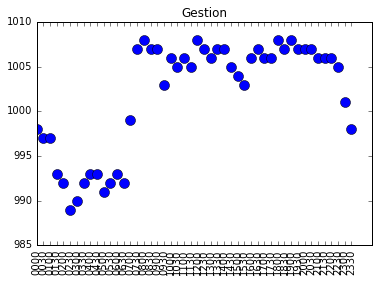

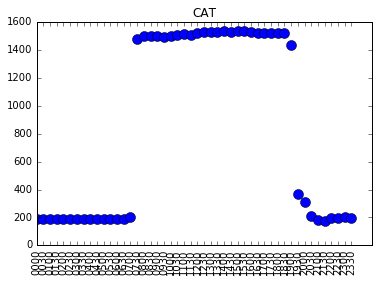

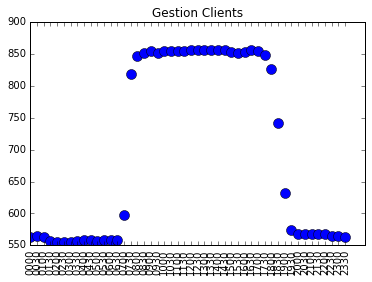

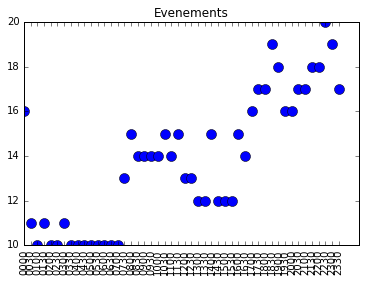

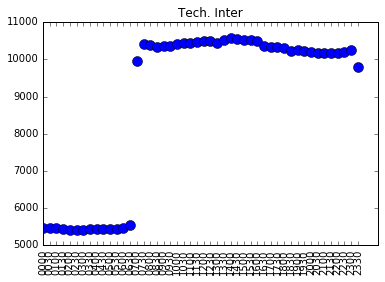

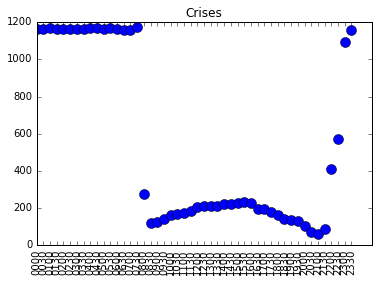

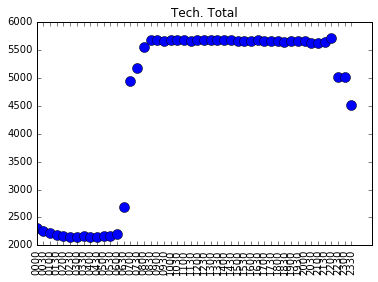

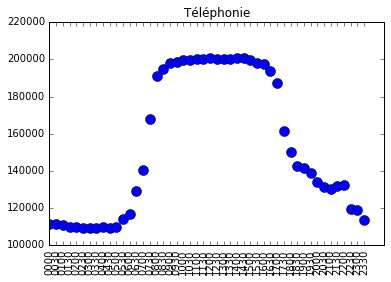

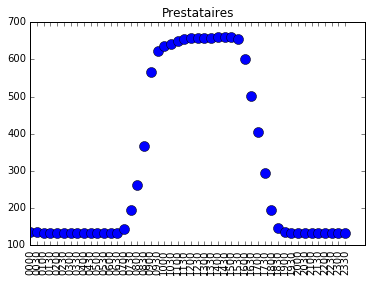

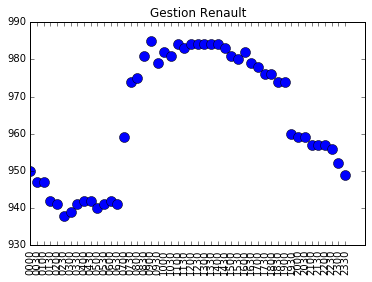

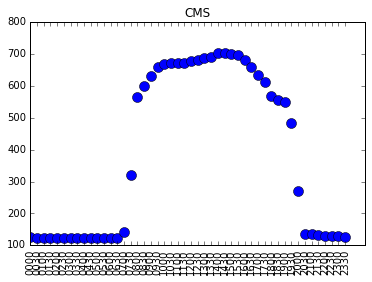

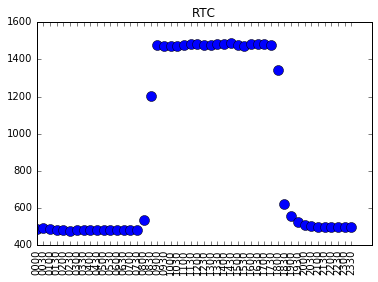

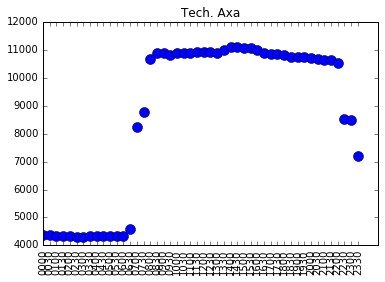

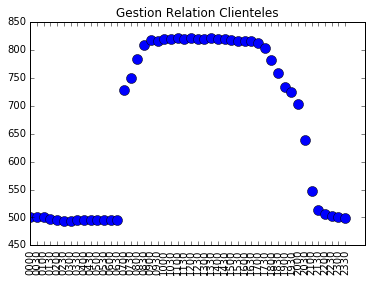

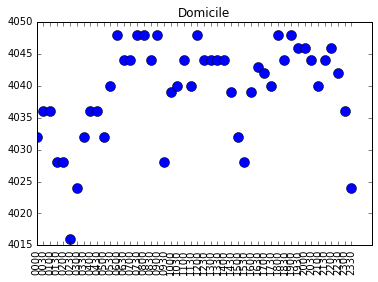

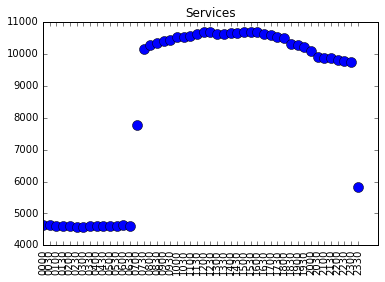

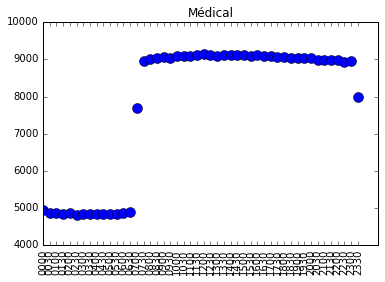

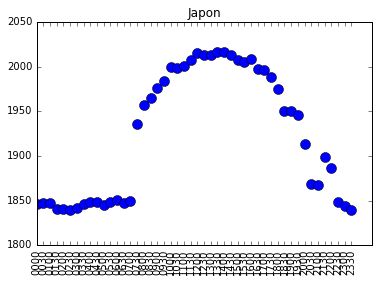

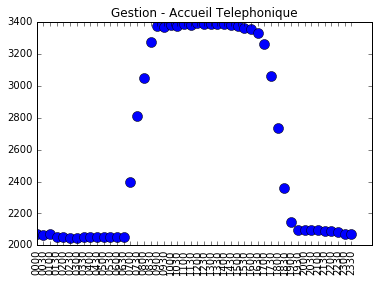

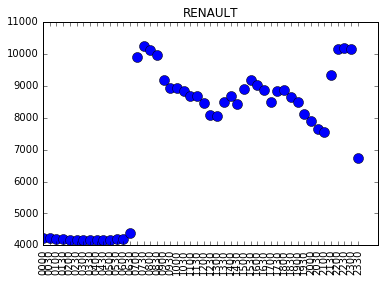

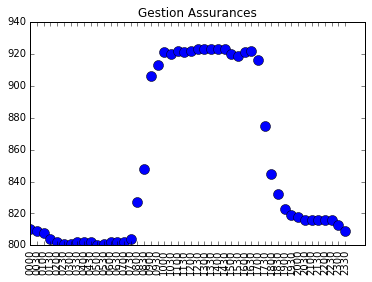

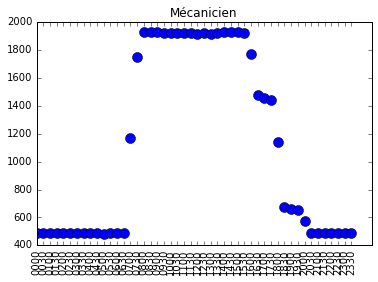

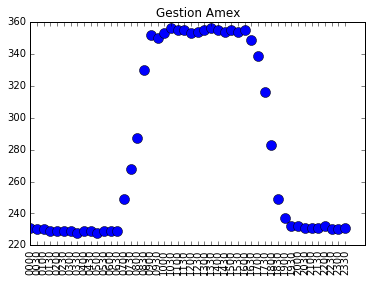

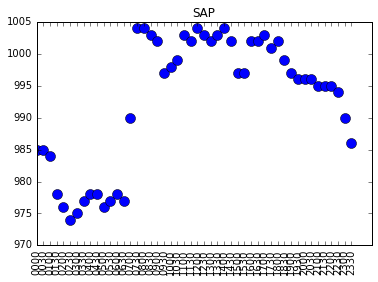

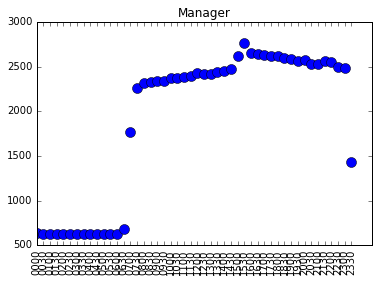

In [56]:
for assignement in occByHourMinByAssignement.keys():
    counterAsArr = np.array(sorted(occByHourMinByAssignement[assignement].items(), key=operator.itemgetter(0), reverse=False))
    plt.figure()
    plt.plot(range(counterAsArr.shape[0]), counterAsArr[:,1], 'o', ms=10)
    plt.xticks(range(counterAsArr.shape[0]), counterAsArr[:,0], rotation='vertical')
    plt.title(assignement)